# Data disponibles

**application_train et application_test** : dataset de train et de test avec informations sur les demandes de prêts auprès de Home Credit. Chaque prêt a une ligne et est identifié par **SK_ID_CURR**. Le jeu de train dispose d'une **target** :
-  0 indique que le prêt est remboursé
-  1 indique que le prêt n'est pas remboursé

**bureau** : données sur les précédents crédits d'un client auprès d'autres institutions financières. Chaque crédit a une ligne. Un prêt des datasets **application** peuvent avoir **plusieurs anciens crédits**.

**bureau_balance** : données mensuelles sur les anciens crédits de **bureau**. Chaque ligne est un mois d'un ancien crédit, un ancien crédit peut avoir peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit

**previous_application** : précédentes candidatures pour un prêt chez Home Credit pour les clients qui ont un prêt dans les datasets **application**. Un prêt actuel peut avoir plusieurs anciennes candidatures. Chaque candidature a une ligne identifiée par **SK_ID_PREV**

**POS_CASH_BALANCE** : données mensuelles sur les points de vente, ou les prêts en espèces que les clients ont eu aurpès de Home Credit. Chaque ligne correspond à un mois d'un point de vente ou d'un prêt en espèce précédent. Un anciens prêt peut avoir plusieurs lignes

**credit_card_balance** : données mensuelles sur d'anciennes cartes de crédit que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois du solde de la carte. Une carte peut avoir plusieurs lignes.

**installments_payments** : historique de paiement pour les précédents prêts auprès de Home Credit. Une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

![image.png](attachment:image.png)

In [50]:
# Librairie exploration et cleaning
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os
from os import listdir
import pickle 

pd.set_option("display.max_columns", 200)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')



# Modélisation
from sklearn.pipeline import make_pipeline

# Modèles utilisés
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
#import xgboost as xgb

# Preprocessing et tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedShuffleSplit, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV

# Métriques
from sklearn.metrics import roc_auc_score

# Imbalanced data
import imblearn
from imblearn.over_sampling import SMOTE

# Interprétabilité 
import shap
import lime 
from lime import lime_tabular

In [2]:
# Fonctions

# Valeurs manquantes
from p7_functions import missing_values_table
from p7_functions import remove_missing_columns
# Barplot sur application_train pour les types de prêts et pourcentage, pour les prêts non remboursés (TARGET = 1)
from p7_functions import plot_stats
# Utilisation de la mémoire
from p7_functions import return_size
from p7_functions import convert_types
# Traitement des dataframe
from p7_functions import app_train_engineering
from p7_functions import agg_numeric
from p7_functions import agg_categorical

# Encoder
from p7_functions import one_hot_encoder

# Feature importance
from p7_functions import feature_importance_model
from p7_functions import plot_feature_importance

# Shap / Lime
from p7_functions import local_interpretability_shap
from p7_functions import local_interpretability_lime

In [3]:
# Chemin de fichier
#path = "/Users/antoinemorvan/Documents/Openclassrooms/P7/datasets/"
# Version windows
path = "/Users/antoinemorvan/Documents/openclassrooms/P7/data/"
# Datasets
app_train = pd.read_csv(path+"application_train.csv")
app_test = pd.read_csv(path+"application_test.csv")
bureau = pd.read_csv(path+"bureau.csv")
bureau_balance = pd.read_csv(path+"bureau_balance.csv")
previous_app = pd.read_csv(path+"previous_application.csv")
#pos_cash_balance = pd.read_csv(path+"POS_CASH_BALANCE.csv") 
#credit_card_balance = pd.read_csv(path+"credit_card_balance.csv")
#installments_payments = pd.read_csv(path+"installments_payments.csv")

In [4]:
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
# Supprime les colonnes d'informations sur les logements (conserve 4 de ces variables)
col_to_drop = app_train.iloc[:,48:91].columns
#print(col_to_drop)
app_train = app_train.drop(columns = col_to_drop)

In [6]:
# Feature engineering d'application_train
train = app_train_engineering(app_train, num_rows = None, nan_as_category = False)
print(train.shape)

(307511, 184)


## Bureau

In [7]:
print(bureau.shape)
bureau.head()

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [8]:
# Valeurs manquantes
bureau_missing_values = missing_values_table(bureau)
bureau_missing_values.head(10)

Le Dataframe sélectionné a 17 colonnes.
Il y a 7 colonnes avec des données manquantes.


,Missing Values,% of Total Values
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


In [9]:
# Crédits actifs
active_credit_perc = (len(bureau.loc[bureau['CREDIT_ACTIVE'] == 'Active']) / len(bureau))*100
closed_credit_perc = (len(bureau.loc[bureau['CREDIT_ACTIVE'] == 'Closed']) / len(bureau))*100
print(f"Crédits actifs en % :   {active_credit_perc}")
print(f"Crédits inactifs en % : {closed_credit_perc}")

Crédits actifs en % :   36.739496209570106
Crédits inactifs en % : 62.87901385901419


In [10]:
# A utiliser pour supprimer les colonnes avec des données manquantes supérieures à un seuil à 50%
bureau = remove_missing_columns(bureau)

Il y a 2 de colonnes avec plus de 50% de valeurs manquantes.


In [11]:
# Imputation des données manquantes
bureau['DAYS_CREDIT_UPDATE'] = np.where(bureau['DAYS_CREDIT_UPDATE'].isna(),
                                        bureau['DAYS_CREDIT_UPDATE'].mean(),
                                        bureau['DAYS_CREDIT_UPDATE'])

bureau.fillna(0, inplace = True)

In [12]:
# Valeurs manquantes
bureau_missing_values = missing_values_table(bureau)
bureau_missing_values.head(10)

Le Dataframe sélectionné a 15 colonnes.
Il y a 0 colonnes avec des données manquantes.


,Missing Values,% of Total Values


In [13]:
# Aggrégation et feature engineering de bureau
bureau = convert_types(bureau, print_info = True)
bureau_num_agg = agg_numeric(bureau, 'SK_ID_CURR', 'bureau')
bureau_cat_agg = agg_categorical(bureau, 'SK_ID_CURR', 'bureau')
print(bureau_num_agg.shape)
print(bureau_cat_agg.shape)

Utilisation de la mémoire avant traitement : 0.21 gb.
Nouvelle utilisation de la mémoire: 0.09 gb.
(305811, 42)
(305811, 46)


## Bureau_balance

In [14]:
print(bureau_balance.shape)
bureau_balance.head()

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [15]:
# Valeurs manquantes
bb_missing_values = missing_values_table(bureau_balance)
bb_missing_values.head(10)

Le Dataframe sélectionné a 3 colonnes.
Il y a 0 colonnes avec des données manquantes.


,Missing Values,% of Total Values


In [16]:
# A utiliser pour supprimer les colonnes avec des données manquantes supérieures à un seuil à 50%
bureau_balance = remove_missing_columns(bureau_balance)

Il y a 0 de colonnes avec plus de 50% de valeurs manquantes.


In [17]:
# Aggrégation et feature engineering de bureau_balance
bureau_balance = convert_types(bureau_balance, print_info = True)
bb_num_agg = agg_numeric(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
bb_cat_agg = agg_categorical(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
print(f"Shape de bb_num_agg : {bb_num_agg.shape}")
print(f"Shape de bb_cat_agg : {bb_cat_agg.shape}")

# Aggrégation de bureau balance par client

# Merge de bureau balance numérique et catégoriel
bureau_by_loan = bb_num_agg.merge(bb_cat_agg, right_index = True,
                                 left_on = 'SK_ID_BUREAU', how = 'outer')

# Inclut SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggrège les stats pour chaque client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']),
                                       'SK_ID_CURR', 'client')

print(f"Shape de bureau_balance_by_client : {bureau_balance_by_client.shape}")

Utilisation de la mémoire avant traitement : 0.66 gb.
Nouvelle utilisation de la mémoire: 0.25 gb.
Shape de bb_num_agg : (817395, 6)
Shape de bb_cat_agg : (817395, 16)
Shape de bureau_balance_by_client : (305811, 86)


# Merge les dataframes

In [18]:
credit_data = train.merge(bureau_num_agg, on = 'SK_ID_CURR', how = 'left')
credit_data = credit_data.merge(bureau_cat_agg, on = 'SK_ID_CURR', how = 'left')
credit_data = credit_data.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
print(credit_data.shape)

(307511, 356)


Les fonctions agg_numeric et agg_categorical peuvent être utilisées sur les autres dataframes pour augmenter le nombre de variables et chercher à améliorer les modèles. Ce n'est pas fait dans ce notebook dans un souci de temps de calcul

# Variables colinéaires

In [19]:
# data_cleaning est utilisé pour optimiser le dataframe credit_data avant la modélisation
data_cleaning = credit_data.copy()
print(data_cleaning.shape)

(307511, 356)


In [20]:
# Seuil pour retirer les variables coliénaires
threshold = 0.9

# Matrice de corrélation en valeur absolue
corr_matrix = data_cleaning.corr().abs()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Sélection des colonnes au-dessus du seuil
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('Il y a %d des colonnes à supprimer.' % (len(to_drop)))

# Print corrélations
upper.head()

Il y a 36 des colonnes à supprimer.


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_CURRENCY_currency 1_count,client_bureau_balance_MONTHS_BALANCE_sum_sum,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_STATUS_4_count_norm_sum,client_bureau_balance_STATUS_5_count_norm_sum,client_bureau_balance_STATUS_4_count_sum,client_bureau_balance_STATUS_5_count_sum,client_bureau_balance_STATUS_3_count_norm_sum,client_bureau_balance_STATUS_3_count_sum,client_bureau_balance_STATUS_2_count_norm_sum,client_bureau_balance_STATUS_2_count_sum,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_STATUS_5_count_norm_min,client_bureau_balanc

In [21]:
print(to_drop)

['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'OBS_60_CNT_SOCIAL_CIRCLE', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA', 'DAYS_EMPLOYED_PERC', 'bureau_DAYS_ENDDATE_FACT_sum', 'bureau_DAYS_CREDIT_UPDATE_sum', 'bureau_CREDIT_DAY_OVERDUE_sum', 'bureau_AMT_CREDIT_SUM_OVERDUE_sum', 'bureau_CNT_CREDIT_PROLONG_sum', 'bureau_AMT_CREDIT_SUM_LIMIT_sum', 'bureau_AMT_CREDIT_SUM_DEBT_sum', 'bureau_CREDIT_TYPE_Mobile operator loan_count', 'bureau_CREDIT_TYPE_Interbank credit_count', 'bureau_CREDIT_ACTIVE_Closed_count_norm', 'bureau_CREDIT_CURRENCY_currency 1_count_norm', 'bureau_CREDIT_ACTIVE_Closed_count', 'bureau_CREDIT_TYPE_Consumer credit_count', 'bureau_CREDIT_CURRENCY_currency 1_count', 'client_bureau_balance_MONTHS_BALANCE_sum_mean', 'client_bureau_balance_MONTHS_BALANCE_min_sum', 'client_bureau_balance_MONTHS_BALANCE_mean_sum', 'client_bureau_balance_MONTHS_BALANCE_min_min', 'client_bureau_balance_MONTHS_BALANCE_min_mean', 'client_bureau_bal

In [22]:
# Drop les variables colinéaires > threshold
data_cleaning = data_cleaning.drop(columns = to_drop)
print(data_cleaning.shape)

(307511, 320)


# Valeurs manquantes

In [23]:
# Data_cleaning
data_missing_values = missing_values_table(data_cleaning)
data_missing_values.head()

Le Dataframe sélectionné a 320 colonnes.
Il y a 143 colonnes avec des données manquantes.


,Missing Values,% of Total Values
client_bureau_balance_STATUS_C_count_max,215280,70.0
client_bureau_balance_STATUS_2_count_mean,215280,70.0
client_bureau_balance_STATUS_2_count_norm_mean,215280,70.0
client_bureau_balance_STATUS_1_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_max,215280,70.0


Les données manquantes proviennent des Identifiants (SK_ID_CURR) n'ayant pas d'informations dans bureau_balance

In [24]:
print(data_missing_values['% of Total Values'].nunique())
print(data_missing_values['% of Total Values'].unique())

2
[70.  14.3]


In [25]:
# A utiliser pour supprimer les colonnes avec des données manquantes supérieures à un seuil à 50%
data_cleaning = remove_missing_columns(data_cleaning)

Il y a 53 de colonnes avec plus de 50% de valeurs manquantes.


In [26]:
data_cleaning.shape

(307511, 267)

In [27]:
# Imputation par la moyenne pour les feature avec 14% de données manquantes
missing_values_columns = data_missing_values.loc[data_missing_values['% of Total Values'] == 14.3].index.tolist()
for col in missing_values_columns:
    data_cleaning[col] = np.where(data_cleaning[col].isna(),
                        data_cleaning[col].mean(),
                        data_cleaning[col])

In [28]:
# Data cleaning
data_missing_values = missing_values_table(data_cleaning)

Le Dataframe sélectionné a 267 colonnes.
Il y a 0 colonnes avec des données manquantes.


In [29]:
# Stock le dataframe cleané dans un pickle
f = open('data_cleaning.pkl','wb')
pickle.dump(data_cleaning,f)
f.close()

# Modélisation
Code à décommenter pour exécuter les modèles non tunés

In [30]:
# Dataset et cible
target = 'TARGET'
data, target = data_cleaning.drop(columns = target), data_cleaning[target]
# Supprime l'identifiant client
data = data.drop(columns = 'SK_ID_CURR')

In [31]:
X = data
y = target

# Jeu de données déséquilibré : stratification aléatoire
shuffle = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 0) 

# Train Test
for train_index, test_index in shuffle.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print("Training set: {} \nTesting set: {} \n".format(X_train.shape[0], X_test.shape[0]))

Training set: 230633 
Testing set: 76878 



## Dummy Classifier

In [32]:
# Dummy classifier
#dummy = make_pipeline(StandardScaler(), DummyClassifier(strategy="most_frequent"))

# Fit
#dummy.fit(X_train, y_train)
# Predict
#target_pred = dummy.predict(X_test)

# ROC AUC
#dummy_auc = roc_auc_score(y_test, [i[1] for i in dummy.predict_proba(X_test)])
#print(f"ROC AUC du dummy classifier : {dummy_auc:.3f}")

## Régression logistique

In [33]:
# Rgégression logistique
#lr = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0))
#print(lr.get_params())

# Fit
#lr.fit(X_train, y_train)

# ROC AUC
#lr_auc = roc_auc_score(y_test, [i[1] for i in lr.predict_proba(X_test)])
#print(f"ROC AUC de la régression logistique : {lr_auc:.3f}")

**ROC AUC de la régression logistique : 0.743**

In [34]:
# Régression logistique avec class weight
#lr_balanced = make_pipeline(StandardScaler(), LogisticRegression(class_weight = 'balanced', random_state = 0))

# Fit
#lr_balanced.fit(X_train, y_train)

# ROC AUC
#lr_balanced_auc = roc_auc_score(y_test, [i[1] for i in lr_balanced.predict_proba(X_test)])
#print(f"ROC AUC de la régression logistique : {lr_balanced_auc:.3f}")

**ROC AUC de la régression logistique : 0.743**

## Random Forest Classifier

In [35]:
# Random forest classifier
#rfc = make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 0))
#print(rfc.get_params())

# Fit
#rfc.fit(X_train, y_train)

# ROC AUC
#rfc_auc = roc_auc_score(y_test, [i[1] for i in rfc.predict_proba(X_test)])
#print(f"ROC AUC du random forest : {rfc_auc:.3f}")

**ROC AUC de du random forest : 0.714**

In [36]:
# Random forest classifier avec class weight
#rfc_balanced = make_pipeline(StandardScaler(), RandomForestClassifier(class_weight = 'balanced', random_state = 0))
#print(rfc.get_params())

# Fit
#rfc_balanced.fit(X_train, y_train)

# ROC AUC
#rfc_balanced_auc = roc_auc_score(y_test, [i[1] for i in rfc_balanced.predict_proba(X_test)])
#print(f"ROC AUC du random forest : {rfc_balanced_auc:.3f}")

**ROC AUC de du random forest : 0.730**

## Gradient Boosting Classifier

In [37]:
# Gradient boosting classifier
#gdbc = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state = 0))

# Fit
#gdbc.fit(X_train, y_train)

# ROC AUC
#gdbc_auc = roc_auc_score(y_test, [i[1] for i in gdbc.predict_proba(X_test)])
#print(f"ROC AUC du gradient boosting : {gdbc_auc:.3f}")

**ROC AUC du gradient boosting classifier : 0.760**

# XGBoost Classifier

In [38]:
# XGboost classifier
#xgb = make_pipeline(StandardScaler(), xgb.XGBClassifier(random_state = 0))
#print(gdbc.get_params())

# Fit
#xgb.fit(X_train, y_train)

# ROC AUC
#xgb_auc = roc_auc_score(y_test, [i[1] for i in xgb.predict_proba(X_test)])
#print(f"ROC AUC du gradient boosting : {xgb_auc:.3f}")

**ROC AUC du XGBOOST Classifier : 0.765**

# Smote

In [39]:
# SMOTE sur X_train, y_train
#X_resampled, y_resampled = SMOTE(random_state = 0).fit_resample(X_train, y_train)

# Rgégression logistique avec SMOTE
#lr_smote = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0))
#print(lr.get_params())

# Fit
#lr_smote.fit(X_resampled, y_resampled)

# ROC AUC
#lr_smote_auc = roc_auc_score(y_test, [i[1] for i in lr_smote.predict_proba(X_test)])
#print(f"ROC AUC de la régression logistique : {lr_smote_auc:.3f}")


# Random forest classifier avec SMOTE
#rfc_smote = make_pipeline(StandardScaler(), RandomForestClassifier(random_state = 0))
#print(rfc_smote.get_params())

# Fit
#rfc_smote.fit(X_resampled, y_resampled)

# ROC AUC
#rfc_smote_auc = roc_auc_score(y_test, [i[1] for i in rfc_smote.predict_proba(X_test)])
#print(f"ROC AUC du random forest : {rfc_smote_auc:.3f}")


# Gradient boosting classifier
#gdbc_smote = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state = 0))
#print(gdbc_smote.get_params())

# Fit
#gdbc_smote.fit(X_resampled, y_resampled)

# ROC AUC
#gdbc_smote_auc = roc_auc_score(y_test, [i[1] for i in gdbc_smote.predict_proba(X_test)])
#print(f"ROC AUC du gradient boosting : {gdbc_smote_auc:.3f}")


# XGBoost classifier
#xgb_smote = make_pipeline(StandardScaler(), xgb.XGBClassifier(random_state = 0))
#print(gdbc.get_params())

# Fit
#xgb_smote.fit(X_resampled, y_resampled)

# ROC AUC
#xgb_smote_auc = roc_auc_score(y_test, [i[1] for i in xgb_smote.predict_proba(X_test)])
#print(f"ROC AUC du gradient boosting : {xgb_smote_auc:.3f}")

**Résultats des modèles (ROC AUC) :** 
- Dummy classifier : 0.5
- Régression logistique : 0.743 (0.743 avec class weight)
- Random forest classifier : 0.714 (0.730 avec class wieght)
- Gradient boosting classifier : 0.760
- XGBoost classifier : 0.765

**Avec Smote**
- Régression logistique : 0.711
- Random forest classifier : 0.707
- Gradient boosting classifier : 0.699 
- XGBoost classifier : 0.752

**On utilisera un XGBoost classifier sans SMOTE pour la suite**

# Gradient boosting feature selection & tuning

In [40]:
# Gradient Boosting classifier
clf = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state = 0))

# Fit
clf.fit(X_train, y_train)

# ROC AUC
clf_auc = roc_auc_score(y_test, [i[1] for i in clf.predict_proba(X_test)])
print(f"ROC AUC du gradient boosting : {clf_auc:.3f}")

ROC AUC du gradient boosting : 0.760


In [41]:
# Feature importance
feature_importance = feature_importance_model(clf, X_train)
print(feature_importance.shape)
feature_importance.head(10)

(265, 3)


,Importance,Importance_cumulee,Variable
0,0.291437,0.291437,EXT_SOURCE_2
1,0.281634,0.573071,EXT_SOURCE_3
2,0.071101,0.644172,PAYMENT_RATE
3,0.054675,0.698847,EXT_SOURCE_1
4,0.043159,0.742006,DAYS_EMPLOYED
5,0.029273,0.771279,DAYS_BIRTH
6,0.020382,0.791661,CODE_GENDER
7,0.013920,0.805581,bureau_CREDIT_ACTIVE_Active_count
8,0.012155,0.817736,bureau_CREDIT_TYPE_Microloan_count_norm
9,0.011926,0.829662,FLAG_DOCUMENT_3


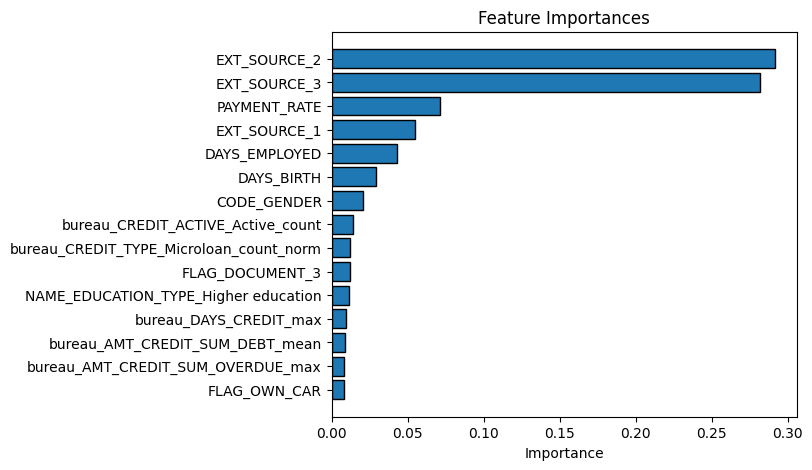

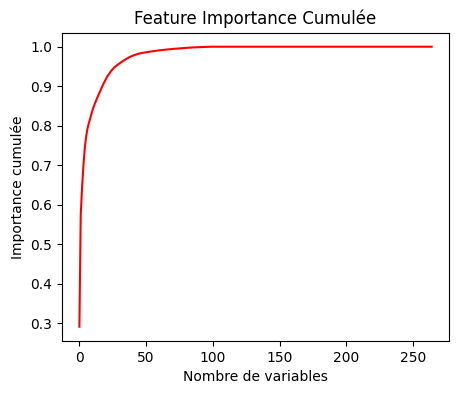

19 variables requises pour 0.90 d'importance cumulée


In [42]:
# Plot feature importance
plot_feature_importance(feature_importance)

## Nouveau dataset

In [46]:
# Copie le dataset et réduit le nombre de variables
data_gbdc = data_cleaning.copy()

# Sélectionne les 50 variables avec la plus grande feature importance (plusieurs tests avant ce choix)
col_to_drop = feature_importance.iloc[19:]
col_to_drop = col_to_drop['Variable'].tolist()
print(len(col_to_drop))

# Drop les autres variables
data_gbdc = data_gbdc.drop(columns = col_to_drop)
print(data_gbdc.shape)

246
(307511, 21)


In [47]:
# Dataset et cible
target = 'TARGET'
data, target = data_gbdc.drop(columns = target), data_gbdc[target]
# Supprime l'identifiant client
data = data.drop(columns = 'SK_ID_CURR')

X = data
y = target

# Jeu de données déséquilibré : stratification aléatoire
shuffle = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 0) 

# Train Test
for train_index, test_index in shuffle.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("Training set: {} \nTesting set: {} \n".format(X_train.shape[0], X_test.shape[0]))

Training set: 230633 
Testing set: 76878 



## Tuning

In [52]:
activation_gdbc = False
if activation_gdbc:
    start = time.time()
    # Gradient Boosting classifier
    clf = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state = 0))

    # Paramètres
    param_grid_gbdc = {
        'gradientboostingclassifier__learning_rate' : np.linspace(10**(-2), 1, 3),
        'gradientboostingclassifier__n_estimators' : [50, 100, 200],
        'gradientboostingclassifier__max_depth' : [3, 4]}

    # GridSearch
    grid = GridSearchCV(clf, param_grid = param_grid_gbdc,
                        n_jobs=4, scoring = "roc_auc",
                        cv=3)

    # Fit
    grid.fit(X_train, y_train)
    stop = time.time()
    train_time = stop - start
    print(train_time)

    print(f"Meilleurs hyper-paramètres sur le training set : \n"
         f"{grid.best_params_}")

    # ROC AUC
    grid_auc = roc_auc_score(y_test, [i[1] for i in grid.predict_proba(X_test)])
    print(f"ROC AUC du gradient boosting classifier : {grid_auc:.3f}")

2658.6442301273346
Meilleurs hyper-paramètres sur le training set : 
{'gradientboostingclassifier__learning_rate': 0.505, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 100}
ROC AUC du gradient boosting classifier : 0.766


Meilleurs hyper-paramètres sur le training set : 
{'gradientboostingclassifier__learning_rate': 0.505, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 100}

ROC AUC du gradient boosting classifier : 0.766

Le temps d'entraînement avec gridsearch est de 45 minutes

In [55]:
# Meilleurs modèle (paramètres définis via GridSearchCV)
clf = make_pipeline(StandardScaler(), GradientBoostingClassifier(learning_rate = 0.505, max_depth = 3, 
                                      n_estimators = 100, random_state = 0))

# Fit
clf.fit(X_train, y_train)

# ROC AUC
clf_auc = roc_auc_score(y_test, [i[1] for i in clf.predict_proba(X_test)])
print(f"ROC AUC du gradient boosting : {clf_auc:.3f}")

ROC AUC du gradient boosting : 0.766


In [56]:
# Feature importance
feature_importance = feature_importance_model(clf, X_train)
print(feature_importance.shape)
feature_importance.head(10)

(19, 3)


,Importance,Importance_cumulee,Variable
0,0.263029,0.263029,EXT_SOURCE_2
1,0.248130,0.511159,EXT_SOURCE_3
2,0.143128,0.654287,PAYMENT_RATE
3,0.065321,0.719608,EXT_SOURCE_1
4,0.051768,0.771376,DAYS_EMPLOYED
5,0.041224,0.812601,DAYS_BIRTH
6,0.022371,0.834971,bureau_DAYS_CREDIT_max
7,0.021316,0.856288,AMT_ANNUITY
8,0.020621,0.876909,CODE_GENDER
9,0.019275,0.896184,bureau_CREDIT_ACTIVE_Active_count


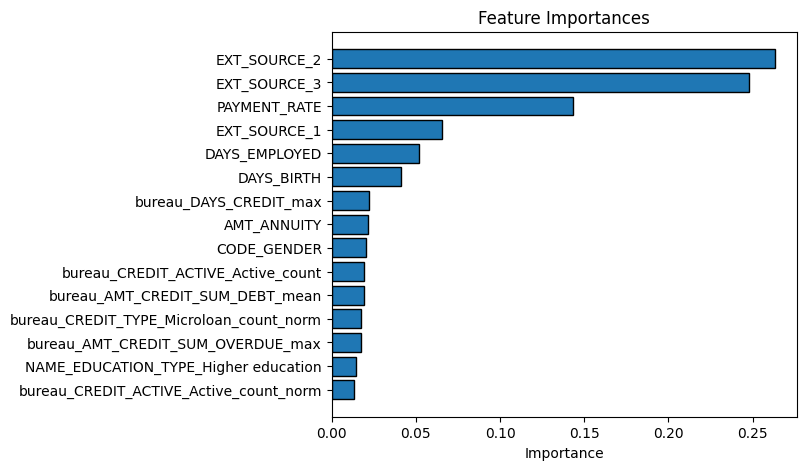

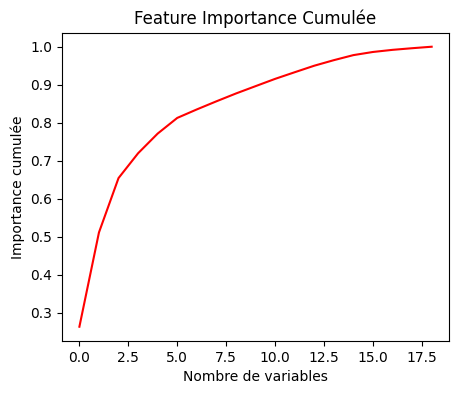

11 variables requises pour 0.90 d'importance cumulée


In [57]:
# Plot feature importance
plot_feature_importance(feature_importance)

Nous garderons ce modèle pour la suite du projet. A noter qu'il est possible d'approfondir le tuning et la sélection de feature pour optimiser le modèle.

Un modèle xgboost classifier permet d'obtenir de meilleures performances (roc auc de 0.774) avec 50 variables et 4h d'entraînement avec gridsearch. Cependant l'utilisation du modèle provoque des erreurs de librairies dans l'utilisation de l'API. Il est donc possible d'améliorer le projet avec ce modèle à condition de résoudre les erreurs de dépendances. 

Dans l'objectif de faire un poc d'API et de dashboard nous continuerons avec le gradient boosting classifier.

In [58]:
# Créer un pickle du modèle 
pickle_out = open("classifier.pkl", "wb")
pickle.dump(clf, pickle_out)
pickle_out.close()

In [59]:
shap_values, observations = local_interpretability_shap(clf, X_test)

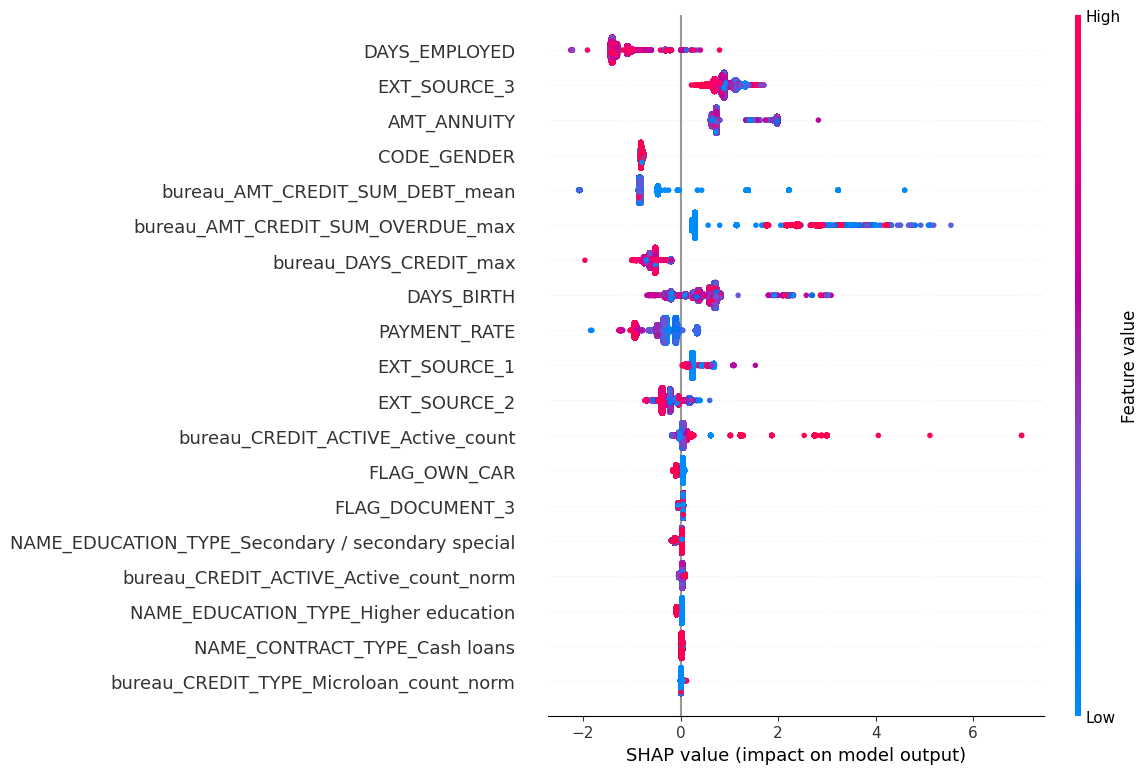

In [60]:
shap.initjs()
shap.summary_plot(shap_values, observations)

In [61]:
# Lime
exp = local_interpretability_lime(clf, X_train, X_test, 0)

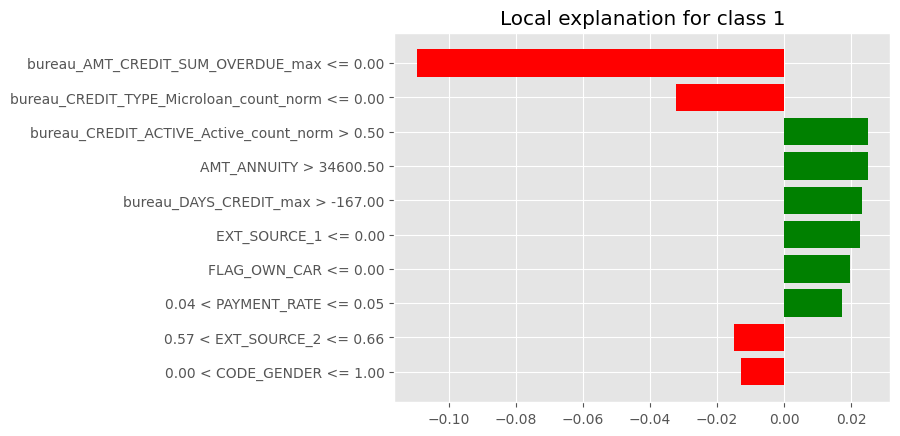

In [62]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()
    plt.show()

In [63]:
exp.show_in_notebook()

In [65]:
#X_train.describe()

# Données pour l'API

In [ ]:
# Créer un pickle du dataset utilisé pour le modèle
#pickle_out = open("dataset.pkl", "wb")
#pickle.dump(data_selection, pickle_out)
#pickle_out.close()

In [68]:
# Réintègre les id clients et la cible après entraînement du modèle
data_index = data_gbdc[['SK_ID_CURR', 'TARGET']].copy()
data_train = pd.merge(X_train, data_index, left_index = True, right_index = True)
data_test = pd.merge(X_test, data_index, left_index = True, right_index = True)
print(data_train.shape)
print(data_test.shape)

(230633, 21)
(76878, 21)


In [69]:
# Créer un pickle du jeu de train
pickle_out = open("train_set.pkl", "wb")
pickle.dump(data_train, pickle_out)
pickle_out.close()

# Créer un pickle du jeu de test
pickle_out = open("test_set.pkl", "wb")
pickle.dump(data_test, pickle_out)
pickle_out.close()

In [70]:
data_test.head()

,CODE_GENDER,FLAG_OWN_CAR,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_3,NAME_CONTRACT_TYPE_Cash loans,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,PAYMENT_RATE,bureau_DAYS_CREDIT_max,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Active_count,SK_ID_CURR,TARGET
241605,1,0,38452.5,-13228,-3282.0,0.000000,0.617123,0.331251,1,1,0,1,0.042512,-129.000000,0.000000,136307.250000,0.000000,0.666667,4.000000,379761,0
306125,1,0,23944.5,-19385,-1021.0,0.611819,0.393986,0.000000,1,1,1,0,0.094011,-1867.000000,0.000000,0.000000,0.000000,0.000000,0.000000,454682,0
292074,0,0,22018.5,-10520,-897.0,0.223285,0.651550,0.474051,1,1,0,1,0.048930,-361.000000,0.000000,33868.125000,0.000000,0.750000,3.000000,438359,1
177062,1,0,32512.5,-12234,-4418.0,0.000000,0.685591,0.669057,1,1,0,1,0.061420,-1061.000000,0.000000,9414.900391,0.000000,0.200000,1.000000,305185,0
250856,1,0,38839.5,-20888,-4687.0,0.000000,0.699304,0.000000,1,1,0,1,0.046493,-489.297817,184.970184,136925.984375,0.004208,0.412972,2.056689,390257,0


In [71]:
pickle_in = open("classifier.pkl", "rb")
model = pickle.load(pickle_in)

In [72]:
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.505,
                                            random_state=0))])